# Goals

## Filling in gaps-- or, "Point to Grid"

1. Use nearest neighbors to grid some data.
2. Use Kriging to grid some data.

Let's load the `meuse` dataset.

In [ ]:
install.packages("sp")

In [ ]:
library(sp)

In [ ]:
data(meuse)

In [ ]:
head(meuse)

In [ ]:
library(ggplot2)
ggplot(meuse, aes(x, y, colour=elev)) + geom_point() + coord_fixed()

*Want to predict elevation at a new location (and a grid of new locations).*

In [ ]:
x.new = XXX
y.new = YYY

## Version 1: Nearest neighbors

Step 1: Calculate distance to every other point.

In [ ]:
dists = sqrt((meuse$x - x.new)^2 + (meuse$y - y.new)^2)

In [ ]:
dists

Step 2: Choose the nearest neighbors

In [ ]:
which.min(dists)

In [ ]:
meuse$elev[NNN]

In [ ]:
dists[order(dists)]

In [ ]:
meuse$elev[order(dists)[1:MMM]]

In [ ]:
mean(meuse$elev[order(dists)[1:MMM]])

Step 3: Do this for a whole grid

In [ ]:
xx.all = seq(x.new - 500, x.new + 500, by=10)
yy.all = seq(y.new - 500, y.new + 500, by=10)

In [ ]:
grid = expand.grid(x=xx.all, y=yy.all)

In [ ]:
grid$elev = NA
for (ii in 1:nrow(grid)) {
    dists = sqrt((meuse$x - grid$x[ii])^2 + (meuse$y - grid$y[ii])^2)
    grid$elev[ii] = meuse$elev[which.min(dists)]
}

In [ ]:
ggplot(grid, aes(x, y, fill=elev)) + geom_raster()

In [ ]:
grid$elev = NA
for (ii in 1:nrow(grid)) {
    dists = sqrt((meuse$x - grid$x[ii])^2 + (meuse$y - grid$y[ii])^2)
    grid$elev[ii] = mean(meuse$elev[order(dists)[1:MMM]])
}

In [ ]:
ggplot(grid, aes(x, y, fill=elev)) + geom_raster()

In [ ]:
grid$elev = NA
for (ii in 1:nrow(grid)) {
    dists = sqrt((meuse$x - grid$x[ii])^2 + (meuse$y - grid$y[ii])^2)
    grid$elev[ii] = sum(meuse$elev[order(dists)[1:MMM]] * (MMM:1) / sum(MMM:1))
}

In [ ]:
ggplot(grid, aes(x, y, fill=elev)) + geom_raster()

## Verison 2: Weight based on spatial correlation

Step 1. Calculate spatial correlation using the variogram.

For every pair of points, calculate $(y_i - y_j)^2$.

In [ ]:
results = data.frame()
for (ii in 1:nrow(meuse))
    for (jj in 1:nrow(meuse)) {
        dist = sqrt((meuse$x[ii] - meuse$x[jj])^2 + (meuse$y[ii] - meuse$y[jj])^2)
        sqrdiff = (meuse$elev[ii] - meuse$elev[jj])^2
        results = rbind(results, data.frame(dist, sqrdiff))
    }

In [ ]:
nrow(results)

In [ ]:
ggplot(results, aes(dist, sqrdiff)) + geom_point()

In [ ]:
ggplot(results, aes(dist, sqrdiff)) + geom_point() + geom_smooth()

In [ ]:
mod = loess(sqrdiff ~ dist, data=results)

In [ ]:
results$pred = predict(mod, results)

In [ ]:
ggplot(results, aes(dist, sqrdiff)) + geom_point() + geom_line(aes(y=pred), colour='blue')

Calculate weights for all points less than 1000 away, using loess model.

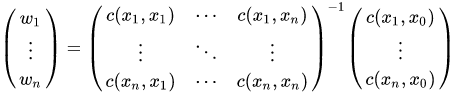

In [ ]:
dists = sqrt((meuse$x - x.new)^2 + (meuse$y - y.new)^2)

In [ ]:
which(dists < 1000)

In [ ]:
included = which(dists < 1000)
mat = matrix(NA, length(included), length(included))
for (ii in 1:length(included)) {
    for (jj in 1:length(included)) {
        dist = sqrt((meuse$x[ii] - meuse$x[jj])^2 + (meuse$y[ii] - meuse$y[jj])^2)
        mat[ii, jj] = predict(mod, data.frame(dist))
    }
}

In [ ]:
image(mat)

In [ ]:
solve(mat)

In [ ]:
weights = solve(mat) %*% predict(mod, data.frame(dist=dists[included]))

In [ ]:
weights

In [ ]:
quantile(weights)

In [ ]:
weights[order(dists[included])[1:3]]

In [ ]:
sum(weights * meuse$elev[included])

Use R package

In [ ]:
install.packages("gstat")
library(gstat)

In [ ]:
coordinates(meuse) = ~ x + y

In [ ]:
mod <- variogram(elev ~ 1, meuse)

In [ ]:
mod

In [ ]:
fit <- fit.variogram(mod, model=vgm("Sph"))

In [ ]:
plot(mod, fit)

In [ ]:
coordinates(grid) <- ~ x + y

In [ ]:
kriged <- krige(elev ~ 1, meuse, grid, model=fit)

In [ ]:
head(kriged)

In [ ]:
grid$elev = kriged$var1.pred

In [ ]:
ggplot(as.data.frame(grid), aes(x, y, fill=elev)) + geom_raster()

In [ ]:
ggplot(as.data.frame(grid), aes(x, y, fill=elev)) + geom_raster() + geom_point(data=as.data.frame(meuse), aes(colour=elev))